# ScaffoldGraph: Scaffold networks and trees

ScaffoldGraph can generate scaffold networks and scaffold trees from SDF and SMILES files.

This simple guide aims to show the very basics of what can be done with ScaffoldNetworks and ScaffoldTrees using ScaffoldGraph, RDKit and the NetworkX API.

In [1]:
# Import scaffoldgraph
import scaffoldgraph as sg

# Import networkx
import networkx as nx

# Import plotting tools
import matplotlib.pyplot as plt
import pandas as pd
# Import rdkit
from rdkit.Chem import Draw
from rdkit import Chem
import mols2grid
import random
import os

In [2]:
# Visualize some molecules in the example SDF file

smiles_file = ('All_selected.smi') # Example SDF file (200 PubChem compounds)
#df_smiles = pd.read_csv(smiles_file, sep=" ", header=None)
#df_smiles.columns=["SMILES", "ZINC_ID"]
#df_smiles.head()
#peek = 15
#Draw.MolsToGridImage([supplier[x] for x in range(peek)])


## Scaffold Networks

Scaffold networks can be generated using the sg.ScaffoldNetwork class

* sg.ScaffoldNetwork.from_sdf(*args, **kwargs)
* sg.ScaffoldNetwork.from_smiles_file(*args, **kwargs)
* sg.Scaffoldnetwork.from_supplier(*args, **kwargs) (custom molecule supplier)

In this guide we will be working with molecules in examples.sdf

#### Note:

The ScaffoldNetwork generator breaks fused ring systems as per the definition in the original publication. If the user wants to preserve fused ring systems then they should use the sg.HierS class which functions in the same way as the ScaffoldNetwork class but does not break fused ring systems. 


In [3]:
# We can generate a scaffold network from this SDF file
# The progress flag tracks the progress of the operation with a progress bar

network = sg.ScaffoldNetwork.from_smiles_file(smiles_file, progress=True)

# We can access the number of molecule nodes and scaffold nodes in the graph
n_scaffolds = network.num_scaffold_nodes
n_molecules = network.num_molecule_nodes

print('\nGenerated scaffold network from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))

ScaffoldNetwork:   0%|                                                                                        …


Generated scaffold network from 13397022 molecules with 4974664 scaffolds



In [4]:
# We can obtain a list of SMILES strings representing scaffolds in the scaffold network

scaffolds = list(network.get_scaffold_nodes())
#print(scaffolds[0:5])
df_scaffolds = pd.DataFrame(scaffolds, columns=["SMILES"])
# Visualize a few of the scaffolds

#sample = 15
#Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in scaffolds[:sample]])
mols2grid.display(df_scaffolds[0:1000], subset=["img", "SMILES"])

MolGridWidget()

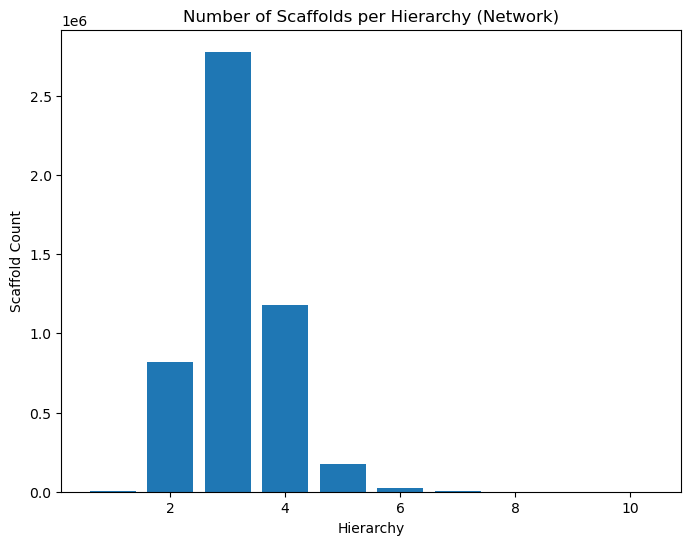

In [5]:
# We can get the number of scaffolds in each hierarchy easily

counts = network.get_hierarchy_sizes()  # returns a collections Counter object
lists = sorted(counts.items())
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Network)')
plt.show()

In [6]:
counts

Counter({3: 2777020,
         4: 1179827,
         2: 816327,
         5: 171928,
         6: 23589,
         7: 2795,
         1: 2146,
         8: 911,
         9: 105,
         10: 16})

ZINCh50000000Yz5 : CCN(C(=O)C1CNC(C)C1)C1CCNC1=O


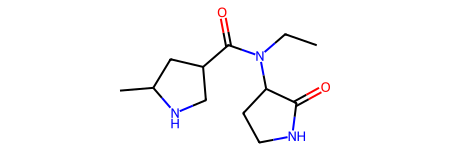

In [7]:
# Molecules are stored in the network with their _Name property as a key
# When using SDF format rdkit assigns the _Name property from the TITLE section
# In this case this refers to a PubChem ID

molecules = list(network.get_molecule_nodes())
#print(molecules[0:6], '\n')

# The SMILES strings for these molecules are accessible in the nodes attributes

mol_id = 15
pubchem_id = molecules[mol_id]
smiles = network.nodes[pubchem_id]['smiles']

print('{} : {}'.format(pubchem_id, smiles))
Chem.MolFromSmiles(smiles)

['ZINCh50000000Yz5', 'O=C(NC1CCNC1=O)C1CCNC1', 'O=C1CCCN1', 'C1CCNC1']


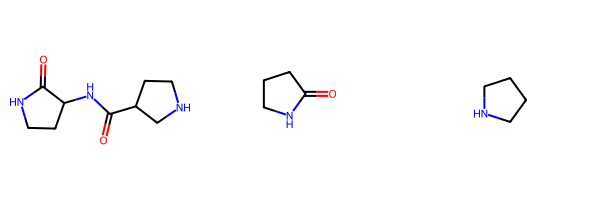

In [8]:
# Using the NetworkX API it is easy to find subscaffolds for a molcule of interest.
# We can use a breadth first search to find subscaffolds of the above molecule example.
# Scaffolds are predecessors of molecules as they form the molecules building blocks.

predecessors = list(nx.bfs_tree(network, pubchem_id, reverse=True))
print(predecessors)  # entry [0] is the search molecule 
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors[1:]])


## Scaffold Trees

Scaffold trees can be generated using the sg.ScaffoldTree class

* sg.ScaffoldTree.from_sdf(*args, **kwargs)
* sg.ScaffoldTree.from_smiles_file(*args, **kwargs)
* sg.ScaffoldTree.from_supplier(*args, **kwargs) (custom molecule supplier)

In this guide we will be working with molecules in examples.sdf

All the examples above can also be applied to the tree structure


In [3]:
# We can generate a scaffold tree from the SDF file just like before

tree = sg.ScaffoldTree.from_smiles_file(smiles_file, progress=True)

# We can access the number of molecule nodes and scaffold nodes in the graph
n_scaffolds = tree.num_scaffold_nodes
n_molecules = tree.num_molecule_nodes

print('\nGenerated scaffold tree from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))

# The output is a forest structure (multiple trees)

print('Graph is a Forest:', nx.is_forest(tree))


ScaffoldTree:   0%|                                                                                           …


Generated scaffold tree from 13397022 molecules with 4403199 scaffolds

Graph is a Forest: False


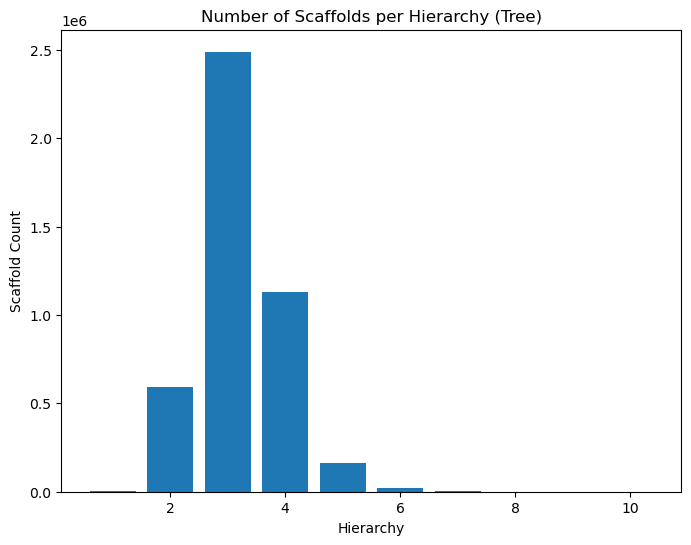

In [4]:
# We can get the number of scaffolds in each hierarchy easily (The numbers are different to the network)

counts = tree.get_hierarchy_sizes()
lists = sorted(counts.items())
x, y = zip(*lists)

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Tree)')
plt.show()

PubChem ID: ZINCpx00000dhtwS
Predecessors of ZINCpx00000dhtwS is Tree: True


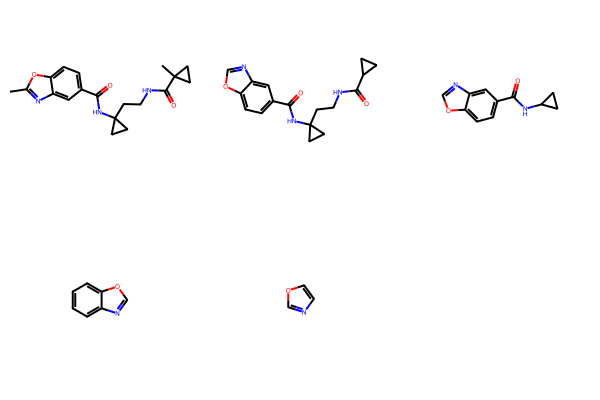

In [5]:
# We can choose a random molecule in the set and view its scaffold predecessors

random_pubchem_id = random.choice(list(tree.get_molecule_nodes()))
print('PubChem ID:', random_pubchem_id)
predecessors = nx.bfs_tree(tree, random_pubchem_id, reverse=True)

# We can validate that one molecules scaffold set forms a tree structure

print('Predecessors of {} is Tree: {}'.format(random_pubchem_id, nx.is_tree(predecessors)))

# Draw these scaffolds

predecessors_list = list(predecessors)
predecessors_list[0] = tree.nodes[predecessors_list[0]]['smiles'] # [0] is pubchem ID
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors_list])

PubChem ID: ZINCm900000uCTVz


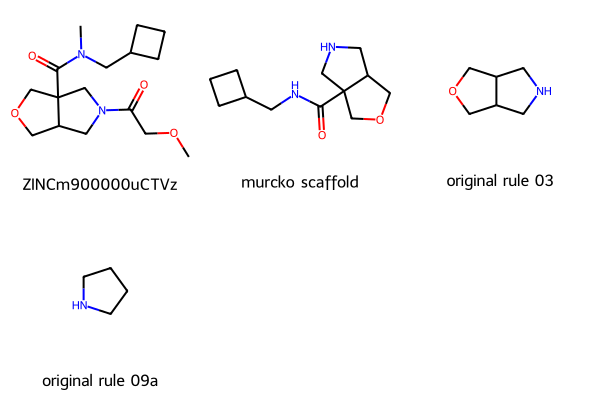

In [6]:
# We may also want to see what prioritization rules have been used at each step
# The name of the rule used is stored in the edge between two scaffolds
# Original rules can be viewed at the original publication (https://pubs.acs.org/doi/10.1021/ci600338x)

random_pubchem_id = random.choice(list(tree.get_molecule_nodes()))
print('PubChem ID:', random_pubchem_id)
predecessors = nx.bfs_tree(tree, random_pubchem_id, reverse=True)

rules = [random_pubchem_id]
for edge in predecessors.edges():
    # we need to get the edge attr from the original tree
    data = tree.edges[edge[::-1]]
    if data['type'] == 0:  # molecule -> scaffold
        rules.append('murcko scaffold')
    else:  # scaffold -> scaffold
        rules.append(data['rule'])

# Draw molecules
predecessors_list = list(predecessors)
predecessors_list[0] = tree.nodes[predecessors_list[0]]['smiles'] # [0] is pubchem ID
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors_list], legends=rules)